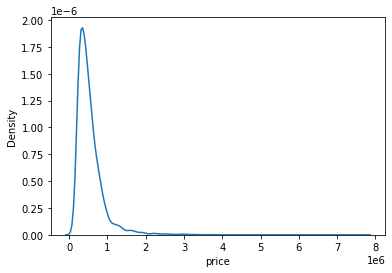

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15030 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15030 non-null  int64  
 1   bedrooms       15030 non-null  int64  
 2   bathrooms      15030 non-null  float64
 3   sqft_living    15030 non-null  int64  
 4   sqft_lot       15030 non-null  int64  
 5   floors         15030 non-null  float64
 6   waterfront     15030 non-null  int64  
 7   view           15030 non-null  int64  
 8   condition      15030 non-null  int64  
 9   grade          15030 non-null  int64  
 10  sqft_above     15030 non-null  int64  
 11  sqft_basement  15030 non-null  int64  
 12  yr_built       15030 non-null  int64  
 13  yr_renovated   15030 non-null  int64  
 14  zipcode        15030 non-null  int64  
 15  lat            15030 non-null  float64
 16  long           15030 non-null  float64
 17  sqft_living15  15030 non-null  int64  
 18  sqft_l

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 데이터 전처리 
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

#### test 01
train = train.loc[train['id']!=456]
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7259]
train = train.loc[train['id']!=2777]

y = train['price']
del train['price']
del train['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# seaborn의 `kdeplot`을 활용해 y분포 확인
sns.kdeplot(y)
plt.show()

# 왼쪽으로 크게 치우쳐 있는 y값 로그변환 
y = np.log1p(y)

# 데이터 형태 확인
train.info()

# rmse 계산을 위한 함수 생성
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    
    for i,model in enumerate(models):
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name+str(i)] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# 그리드 탐색
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 학습결과 예측
"""
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
"""

#save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

model_a = GradientBoostingRegressor(random_state=random_state)
# GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model_b = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
# XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
model_c = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
# LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model_d = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state) 
                                
models = [model_a,model_b,model_c,model_d]
                                
# RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state)

#print(my_GridSearch(model_a, train, y, param_grid, verbose=2, n_jobs=5))
#print(my_GridSearch(model_b, train, y, param_grid, verbose=2, n_jobs=5))
#print(my_GridSearch(model_c, train, y, param_grid, verbose=2, n_jobs=5))
#print(my_GridSearch(model_d, train, y, param_grid, verbose=2, n_jobs=5))

In [3]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [4]:
y_pred = AveragingBlending(models, train, y, test)
print(y_pred)
prediction = np.expm1(y_pred)
print(prediction)

[13.13418051 12.99693517 14.10676119 ... 13.00980291 12.7513473
 12.99502612]
[ 505942.6169979   441058.54715228 1338098.91925152 ...  446770.65789137
  345015.42460139  440217.34277702]


In [5]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = '{}/test_sample.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)

In [6]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for model in models:
        CV_score = np.mean(cross_val_score(model, X=train.values, y=y, cv=kfold))
        print(f"Model: {model.__class__.__name__}, CV score:{CV_score:.4f}")

In [7]:
get_cv_score(models)

Model: GradientBoostingRegressor, CV score:0.8796
Model: XGBRegressor, CV score:0.8894
Model: LGBMRegressor, CV score:0.9022
Model: RandomForestRegressor, CV score:0.8736


In [8]:

model_a = GradientBoostingRegressor(random_state=random_state)
# GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model_b = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
# XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
model_c = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
# LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model_d = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state) 
                                
model_e = LGBMRegressor(random_state=random_state)

models = [model_a,model_b,model_c,model_d,model_e]
get_scores(models , train , y)

,RMSE
RandomForestRegressor3,138052.664828
GradientBoostingRegressor0,128963.259176
XGBRegressor1,113191.498023
LGBMRegressor2,109766.148225
LGBMRegressor4,107546.887330


In [10]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    
save_submission(models[2], train, y, test, 'test', rmsle='2')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_test_RMSLE_2.csv saved!
